In [1]:
#Computer Vision Project
#The following Question must use a CNN based architecture.

#Classification of Time Problem
#Determine the time of the day based on the input image

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils import tensorboard
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch.nn as nn
from PIL import Image

In [3]:
writer = tensorboard.SummaryWriter('runs/experiment_1')

In [4]:
def preprocess_images(image_folder, batch_size = 625):
    # Define transformations to be applied to the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # Add more transformations if needed
    ])

    # Create a dataset from the images in the folder using torchvision's ImageFolder
    dataset = torchvision.datasets.ImageFolder(root = image_folder, transform = transform)

    # Create a DataLoader to handle batching and shuffling of the dataset
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

    return dataloader


image_folder_path = 'timeofday'

#Define the batch size for the DataLoader
batch_size = 625

#Preprocess images and create a DataLoader
data_loader = preprocess_images(image_folder_path, batch_size = batch_size)



In [5]:
# Create The model

import torch.nn as nn
import torch.nn.functional as F

class timeofday_cnn(nn.Module):
    def __init__(self):
        super(timeofday_cnn, self).__init__()
        
        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 3,
                out_channels = 16,
                kernel_size = 5,
                stride = 1,
                padding = 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(16,32,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.linear_1 = nn.Linear(32*56*56,256)
        self.linear_2 = nn.Linear(256,10)
   
    def forward(self,x):
        x_1 = self.conv_1(x)
        x_2 = self.conv_2(x_1)
        x_2 = x_2.view(x_2.size(0), -1)
        out = self.linear_1(x_2)
        
        return out, x

In [6]:
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 6116), started 23:21:26 ago. (Use '!kill 6116' to kill it.)

In [7]:
# Visualize Data

data_sample = iter(data_loader)
images, targets = next(data_sample)
image_grid = torchvision.utils.make_grid(images)
writer.add_image('Sample Time Of Day', image_grid)
writer.close()

In [8]:
model = timeofday_cnn()
print(model)

writer.add_graph(model, images)
writer.close()

timeofday_cnn(
  (conv_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_1): Linear(in_features=100352, out_features=256, bias=True)
  (linear_2): Linear(in_features=256, out_features=10, bias=True)
)


In [9]:
# Define Loss Function
# Define Optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [16]:
# Training loop
import torch.optim as optim


epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

for e in range(epochs):
    
    running_loss = 0.0
    total = 0
    correct = 0
    
    for batch in data_loader:
        images, labels = batch
        
        optimizer.zero_grad()
        outputs = model(images)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate and print average loss and accuracy for the epoch
    epoch_loss = running_loss / len(data_loader)
    epoch_accuracy = correct / total

    print(f'Epoch {e + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%')

Epoch 1/50, Loss: 1.3425, Accuracy: 79.74%
Epoch 2/50, Loss: 0.8553, Accuracy: 80.95%
Epoch 3/50, Loss: 0.1986, Accuracy: 92.82%
Epoch 4/50, Loss: 0.2547, Accuracy: 90.76%
Epoch 5/50, Loss: 0.2144, Accuracy: 92.52%
Epoch 6/50, Loss: 0.1606, Accuracy: 94.70%
Epoch 7/50, Loss: 0.1720, Accuracy: 93.99%
Epoch 8/50, Loss: 0.1496, Accuracy: 94.70%
Epoch 9/50, Loss: 0.1358, Accuracy: 96.20%
Epoch 10/50, Loss: 0.1211, Accuracy: 96.66%
Epoch 11/50, Loss: 0.1061, Accuracy: 97.11%
Epoch 12/50, Loss: 0.0916, Accuracy: 97.67%
Epoch 13/50, Loss: 0.0865, Accuracy: 98.01%
Epoch 14/50, Loss: 0.0737, Accuracy: 98.05%
Epoch 15/50, Loss: 0.0649, Accuracy: 98.50%
Epoch 16/50, Loss: 0.0595, Accuracy: 98.76%
Epoch 17/50, Loss: 0.0531, Accuracy: 98.95%
Epoch 18/50, Loss: 0.0532, Accuracy: 98.99%
Epoch 19/50, Loss: 0.0458, Accuracy: 98.95%
Epoch 20/50, Loss: 0.0412, Accuracy: 99.10%
Epoch 21/50, Loss: 0.0337, Accuracy: 99.25%
Epoch 22/50, Loss: 0.0370, Accuracy: 99.21%
Epoch 23/50, Loss: 0.0334, Accuracy: 99.2

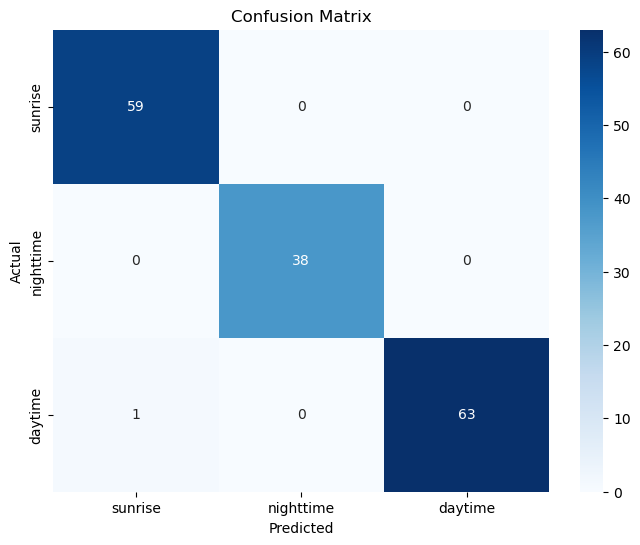

In [18]:
# Create a confusion matrix
cm = confusion_matrix(predicted, labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['sunrise', 'nighttime', 'daytime'], yticklabels=['sunrise', 'nighttime', 'daytime'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
model.eval()
mean = 0
i=0
for images, labels in data_loader:
    predictions = model(images)[0]
    pred_y = torch.max(predictions, 1)[1].data.squeeze()
    accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    mean += accuracy
    i +=1
    
    conf_matrix = confusion_matrix(pred_y, labels)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f'Accuracy of the network on the test images: {accuracy * 100 :.2f}%\n')
print(f"The mean accuracy is: {mean/i * 100 :.2f}%")

Confusion Matrix:
[[208   0   0]
 [  0 183   0]
 [  0   0 234]]
Accuracy of the network on the test images: 100.00%

Confusion Matrix:
[[209   0   1]
 [  0 187   0]
 [  0   0 228]]
Accuracy of the network on the test images: 99.84%

Confusion Matrix:
[[217   0   0]
 [  0 177   0]
 [  0   0 231]]
Accuracy of the network on the test images: 100.00%

Confusion Matrix:
[[230   0   0]
 [  2 167   0]
 [  0   1 225]]
Accuracy of the network on the test images: 99.52%

Confusion Matrix:
[[54  1  0]
 [ 0 40  0]
 [ 0  0 66]]
Accuracy of the network on the test images: 99.38%

The mean accuracy is: 99.75%


In [20]:
save_dir = 'runs/'
model_name = 'experiment_2.pt'

torch.save(model.state_dict, save_dir+model_name)

model_weights = torch.load('runs/experiment_2.pt')
print(model_weights)

<bound method Module.state_dict of timeofday_cnn(
  (conv_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_1): Linear(in_features=100352, out_features=256, bias=True)
  (linear_2): Linear(in_features=256, out_features=10, bias=True)
)>
